# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

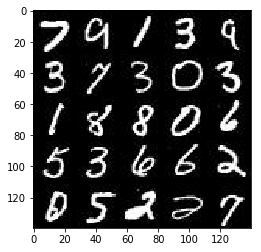

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

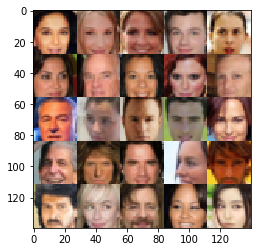

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 4, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 4, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
 
    steps = 0
    
    samples, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
        
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for the generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0 #render dtype=float32 and decrease generator loss
                
                # Run optimizers
                sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                
                if steps % 20 == 0:
                    #print stepwise D/G losses
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

               
                if steps % 100 == 0:
                    #print generator ouput every 100 steps
                     show_generator_output(sess, 9, input_z, image_channels, data_image_mode)

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.7190... Generator Loss: 0.1006
Epoch 1/2... Discriminator Loss: 1.2072... Generator Loss: 1.8855
Epoch 1/2... Discriminator Loss: 1.1232... Generator Loss: 1.2594
Epoch 1/2... Discriminator Loss: 0.9372... Generator Loss: 1.0129
Epoch 1/2... Discriminator Loss: 1.4189... Generator Loss: 0.4373


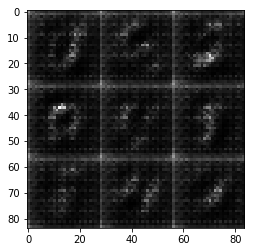

Epoch 1/2... Discriminator Loss: 1.1832... Generator Loss: 0.6592
Epoch 1/2... Discriminator Loss: 1.5891... Generator Loss: 0.3466
Epoch 1/2... Discriminator Loss: 1.3573... Generator Loss: 0.6401
Epoch 1/2... Discriminator Loss: 1.0567... Generator Loss: 0.6884
Epoch 1/2... Discriminator Loss: 0.9611... Generator Loss: 1.0894


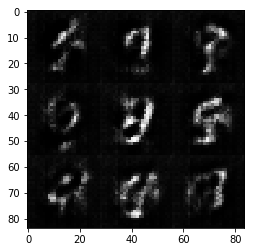

Epoch 1/2... Discriminator Loss: 1.0752... Generator Loss: 0.6099
Epoch 1/2... Discriminator Loss: 1.1224... Generator Loss: 0.6699
Epoch 1/2... Discriminator Loss: 0.8286... Generator Loss: 0.9295
Epoch 1/2... Discriminator Loss: 1.2539... Generator Loss: 0.4375
Epoch 1/2... Discriminator Loss: 0.8079... Generator Loss: 1.0212


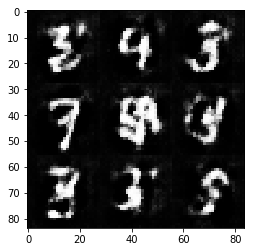

Epoch 1/2... Discriminator Loss: 0.8347... Generator Loss: 1.2996
Epoch 1/2... Discriminator Loss: 0.7528... Generator Loss: 1.2700
Epoch 1/2... Discriminator Loss: 0.7245... Generator Loss: 1.1479
Epoch 1/2... Discriminator Loss: 0.9849... Generator Loss: 0.6863
Epoch 1/2... Discriminator Loss: 0.9626... Generator Loss: 0.9931


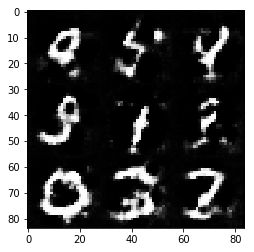

Epoch 1/2... Discriminator Loss: 1.0765... Generator Loss: 1.6644
Epoch 1/2... Discriminator Loss: 1.4270... Generator Loss: 0.3750
Epoch 1/2... Discriminator Loss: 0.8839... Generator Loss: 0.8004
Epoch 1/2... Discriminator Loss: 0.7332... Generator Loss: 1.5939
Epoch 1/2... Discriminator Loss: 1.2369... Generator Loss: 2.0522


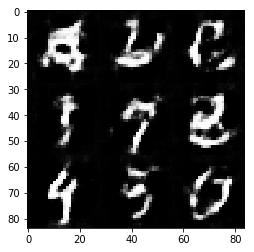

Epoch 1/2... Discriminator Loss: 0.9306... Generator Loss: 1.5479
Epoch 1/2... Discriminator Loss: 0.9753... Generator Loss: 0.7749
Epoch 1/2... Discriminator Loss: 1.0190... Generator Loss: 0.8387
Epoch 1/2... Discriminator Loss: 1.2986... Generator Loss: 0.4241
Epoch 1/2... Discriminator Loss: 0.8857... Generator Loss: 1.1729


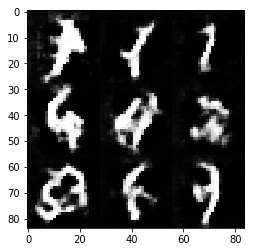

Epoch 1/2... Discriminator Loss: 0.8963... Generator Loss: 0.8179
Epoch 1/2... Discriminator Loss: 0.8917... Generator Loss: 1.1542
Epoch 1/2... Discriminator Loss: 0.8946... Generator Loss: 0.9587
Epoch 1/2... Discriminator Loss: 0.9399... Generator Loss: 1.1640
Epoch 1/2... Discriminator Loss: 1.0048... Generator Loss: 0.6377


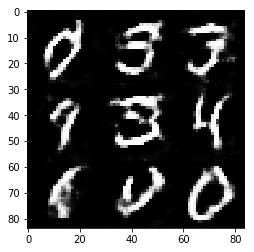

Epoch 1/2... Discriminator Loss: 0.9461... Generator Loss: 1.6522
Epoch 1/2... Discriminator Loss: 1.5776... Generator Loss: 0.2867
Epoch 1/2... Discriminator Loss: 1.0408... Generator Loss: 1.2479
Epoch 1/2... Discriminator Loss: 0.8226... Generator Loss: 1.1062
Epoch 1/2... Discriminator Loss: 0.9504... Generator Loss: 0.7181


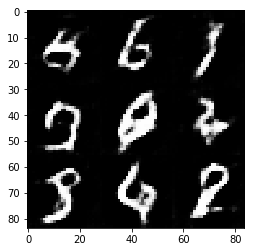

Epoch 1/2... Discriminator Loss: 0.8584... Generator Loss: 0.8278
Epoch 1/2... Discriminator Loss: 0.9791... Generator Loss: 1.0042
Epoch 1/2... Discriminator Loss: 0.9124... Generator Loss: 0.8500
Epoch 1/2... Discriminator Loss: 0.7173... Generator Loss: 1.5789
Epoch 1/2... Discriminator Loss: 0.7217... Generator Loss: 0.9572


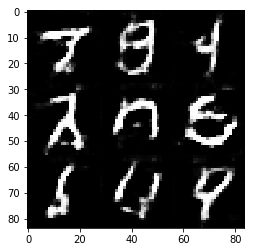

Epoch 1/2... Discriminator Loss: 0.7032... Generator Loss: 1.0833
Epoch 1/2... Discriminator Loss: 0.9797... Generator Loss: 0.6200
Epoch 1/2... Discriminator Loss: 1.5242... Generator Loss: 2.1475
Epoch 1/2... Discriminator Loss: 0.9150... Generator Loss: 0.9182
Epoch 1/2... Discriminator Loss: 0.9455... Generator Loss: 0.8031


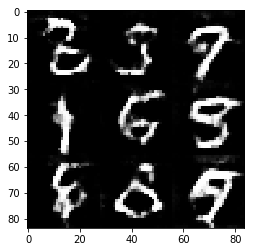

Epoch 1/2... Discriminator Loss: 0.9781... Generator Loss: 0.6428
Epoch 1/2... Discriminator Loss: 0.7174... Generator Loss: 1.6672
Epoch 1/2... Discriminator Loss: 0.8163... Generator Loss: 1.6816
Epoch 1/2... Discriminator Loss: 0.6118... Generator Loss: 1.2145
Epoch 1/2... Discriminator Loss: 2.9476... Generator Loss: 0.1172


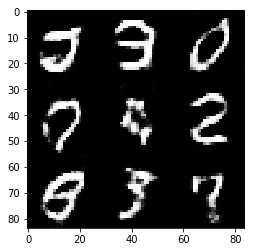

Epoch 1/2... Discriminator Loss: 0.8539... Generator Loss: 0.7721
Epoch 1/2... Discriminator Loss: 0.9685... Generator Loss: 0.6421
Epoch 1/2... Discriminator Loss: 1.1280... Generator Loss: 0.5323
Epoch 1/2... Discriminator Loss: 1.2137... Generator Loss: 0.4890
Epoch 1/2... Discriminator Loss: 0.9005... Generator Loss: 0.6754


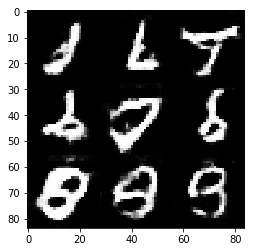

Epoch 2/2... Discriminator Loss: 0.6977... Generator Loss: 0.9639
Epoch 2/2... Discriminator Loss: 0.8447... Generator Loss: 0.7557
Epoch 2/2... Discriminator Loss: 0.7949... Generator Loss: 0.8184
Epoch 2/2... Discriminator Loss: 3.0039... Generator Loss: 0.0809
Epoch 2/2... Discriminator Loss: 1.2112... Generator Loss: 0.5326


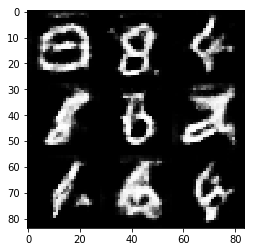

Epoch 2/2... Discriminator Loss: 0.7633... Generator Loss: 0.8541
Epoch 2/2... Discriminator Loss: 0.6990... Generator Loss: 0.8968
Epoch 2/2... Discriminator Loss: 0.8049... Generator Loss: 0.8966
Epoch 2/2... Discriminator Loss: 0.8271... Generator Loss: 0.8381
Epoch 2/2... Discriminator Loss: 0.6375... Generator Loss: 1.0727


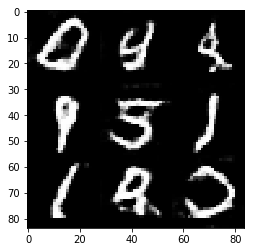

Epoch 2/2... Discriminator Loss: 0.9315... Generator Loss: 0.6876
Epoch 2/2... Discriminator Loss: 1.2194... Generator Loss: 0.4953
Epoch 2/2... Discriminator Loss: 0.6245... Generator Loss: 1.1541
Epoch 2/2... Discriminator Loss: 0.8285... Generator Loss: 0.8274
Epoch 2/2... Discriminator Loss: 0.6322... Generator Loss: 1.1007


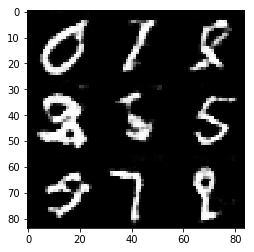

Epoch 2/2... Discriminator Loss: 0.9179... Generator Loss: 2.5591
Epoch 2/2... Discriminator Loss: 0.8131... Generator Loss: 1.0644
Epoch 2/2... Discriminator Loss: 0.7152... Generator Loss: 1.1491
Epoch 2/2... Discriminator Loss: 0.5604... Generator Loss: 1.1054
Epoch 2/2... Discriminator Loss: 0.6821... Generator Loss: 0.9530


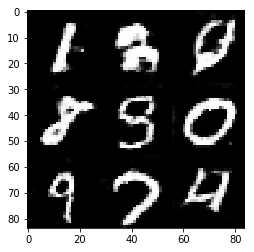

Epoch 2/2... Discriminator Loss: 1.0122... Generator Loss: 0.7032
Epoch 2/2... Discriminator Loss: 0.4171... Generator Loss: 1.4979
Epoch 2/2... Discriminator Loss: 0.5079... Generator Loss: 1.2398
Epoch 2/2... Discriminator Loss: 0.6482... Generator Loss: 1.1458
Epoch 2/2... Discriminator Loss: 0.7499... Generator Loss: 0.8238


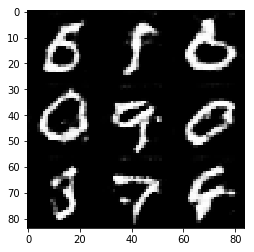

Epoch 2/2... Discriminator Loss: 1.3910... Generator Loss: 0.4336
Epoch 2/2... Discriminator Loss: 0.9498... Generator Loss: 0.7706
Epoch 2/2... Discriminator Loss: 0.6209... Generator Loss: 1.5573
Epoch 2/2... Discriminator Loss: 0.7751... Generator Loss: 0.9527
Epoch 2/2... Discriminator Loss: 0.9182... Generator Loss: 0.7600


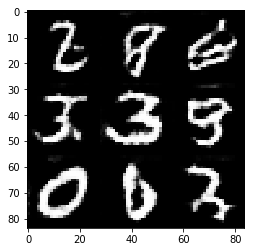

Epoch 2/2... Discriminator Loss: 0.4687... Generator Loss: 1.3234
Epoch 2/2... Discriminator Loss: 1.1563... Generator Loss: 1.8572
Epoch 2/2... Discriminator Loss: 1.3236... Generator Loss: 0.4878
Epoch 2/2... Discriminator Loss: 0.7860... Generator Loss: 1.5614
Epoch 2/2... Discriminator Loss: 0.7464... Generator Loss: 0.9566


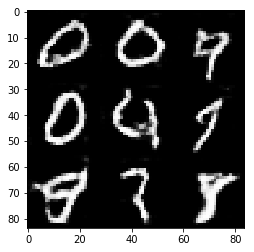

Epoch 2/2... Discriminator Loss: 0.7351... Generator Loss: 3.4111
Epoch 2/2... Discriminator Loss: 0.8683... Generator Loss: 0.7748
Epoch 2/2... Discriminator Loss: 0.9805... Generator Loss: 0.7925
Epoch 2/2... Discriminator Loss: 0.4157... Generator Loss: 1.8190
Epoch 2/2... Discriminator Loss: 1.1713... Generator Loss: 0.5055


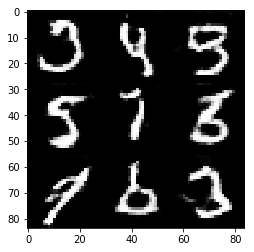

Epoch 2/2... Discriminator Loss: 0.4347... Generator Loss: 1.7044
Epoch 2/2... Discriminator Loss: 1.0763... Generator Loss: 0.6585
Epoch 2/2... Discriminator Loss: 1.6647... Generator Loss: 0.2859
Epoch 2/2... Discriminator Loss: 0.5657... Generator Loss: 2.1354
Epoch 2/2... Discriminator Loss: 0.6588... Generator Loss: 1.2067


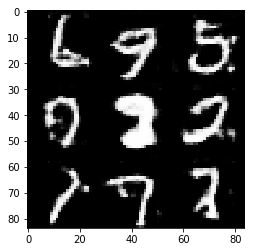

Epoch 2/2... Discriminator Loss: 0.6829... Generator Loss: 1.3760
Epoch 2/2... Discriminator Loss: 1.4694... Generator Loss: 0.4335
Epoch 2/2... Discriminator Loss: 0.7107... Generator Loss: 0.8965
Epoch 2/2... Discriminator Loss: 1.1419... Generator Loss: 0.5840
Epoch 2/2... Discriminator Loss: 0.6646... Generator Loss: 1.0289


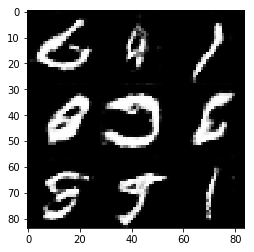

Epoch 2/2... Discriminator Loss: 0.4799... Generator Loss: 1.8201
Epoch 2/2... Discriminator Loss: 0.3699... Generator Loss: 2.7006
Epoch 2/2... Discriminator Loss: 1.3378... Generator Loss: 0.5465
Epoch 2/2... Discriminator Loss: 0.8941... Generator Loss: 0.9652
Epoch 2/2... Discriminator Loss: 0.8007... Generator Loss: 0.8396


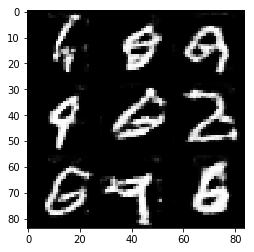

Epoch 2/2... Discriminator Loss: 0.8036... Generator Loss: 0.9246
Epoch 2/2... Discriminator Loss: 1.6016... Generator Loss: 0.3325
Epoch 2/2... Discriminator Loss: 0.6651... Generator Loss: 1.0138
Epoch 2/2... Discriminator Loss: 0.5663... Generator Loss: 1.2599
Epoch 2/2... Discriminator Loss: 0.7448... Generator Loss: 0.9377


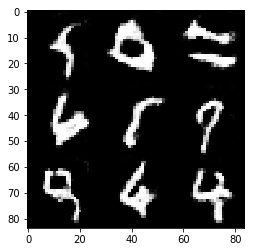

In [12]:
batch_size = 50
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7026... Generator Loss: 1.3958
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 0.6408... Generator Loss: 1.2162
Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 1.2650
Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 1.0395


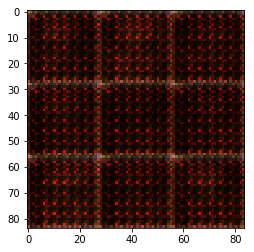

Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 1.8899
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 1.4959
Epoch 1/1... Discriminator Loss: 1.5470... Generator Loss: 0.4520
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.6384


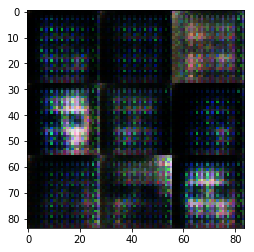

Epoch 1/1... Discriminator Loss: 1.7629... Generator Loss: 0.5335
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.4142
Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 1.1277
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 0.8715


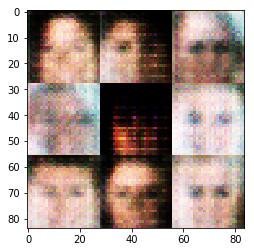

Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.6863... Generator Loss: 1.0549
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.8700


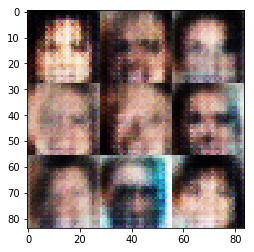

Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.9527... Generator Loss: 0.2422
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.7733... Generator Loss: 0.3273


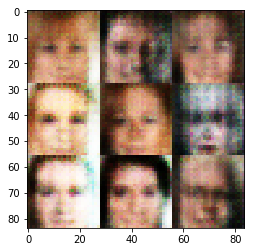

Epoch 1/1... Discriminator Loss: 1.6159... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.5415
Epoch 1/1... Discriminator Loss: 1.5678... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.7566


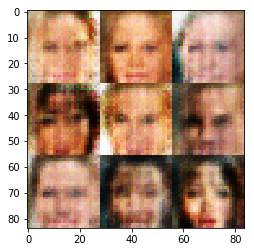

Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.6068... Generator Loss: 0.4053


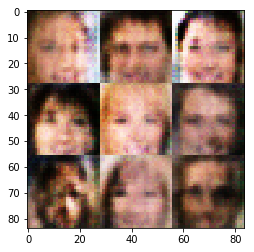

Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 1.5338... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 1.1742


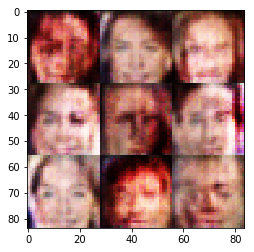

Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.4517
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.7743... Generator Loss: 0.2878


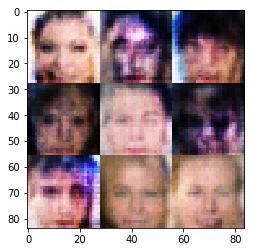

Epoch 1/1... Discriminator Loss: 1.1289... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 1.1199
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 1.5196... Generator Loss: 0.7992


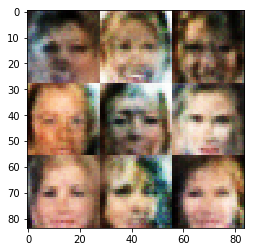

Epoch 1/1... Discriminator Loss: 1.5404... Generator Loss: 0.4779
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 1.1983
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.5896


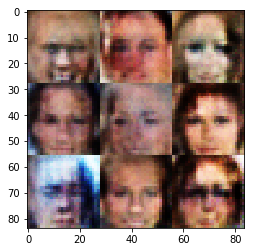

Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 1.0161
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.5394
Epoch 1/1... Discriminator Loss: 1.1270... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.5989


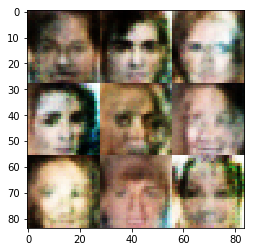

Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.5283
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 2.6676
Epoch 1/1... Discriminator Loss: 1.5688... Generator Loss: 0.3160
Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.3816


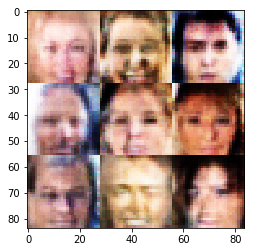

Epoch 1/1... Discriminator Loss: 0.8300... Generator Loss: 2.2436
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.5197
Epoch 1/1... Discriminator Loss: 0.7480... Generator Loss: 0.9377
Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 0.4662... Generator Loss: 4.1735


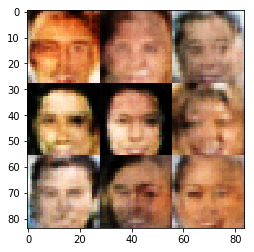

Epoch 1/1... Discriminator Loss: 1.8435... Generator Loss: 4.5242
Epoch 1/1... Discriminator Loss: 0.4777... Generator Loss: 5.2147
Epoch 1/1... Discriminator Loss: 0.5965... Generator Loss: 1.2080
Epoch 1/1... Discriminator Loss: 0.2036... Generator Loss: 3.3512
Epoch 1/1... Discriminator Loss: 0.2763... Generator Loss: 2.5870


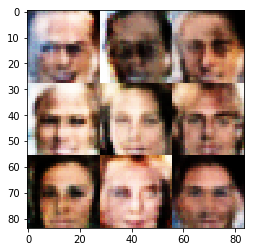

Epoch 1/1... Discriminator Loss: 0.2712... Generator Loss: 2.8589
Epoch 1/1... Discriminator Loss: 0.5449... Generator Loss: 1.3011
Epoch 1/1... Discriminator Loss: 0.4129... Generator Loss: 4.4687
Epoch 1/1... Discriminator Loss: 0.6779... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 0.5107... Generator Loss: 3.0336


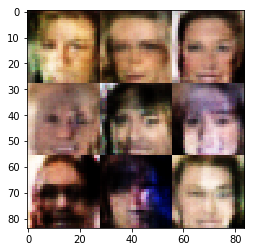

Epoch 1/1... Discriminator Loss: 0.7209... Generator Loss: 0.9004
Epoch 1/1... Discriminator Loss: 0.4670... Generator Loss: 1.3899
Epoch 1/1... Discriminator Loss: 0.8900... Generator Loss: 1.1598
Epoch 1/1... Discriminator Loss: 0.4087... Generator Loss: 3.5124
Epoch 1/1... Discriminator Loss: 0.4751... Generator Loss: 1.5563


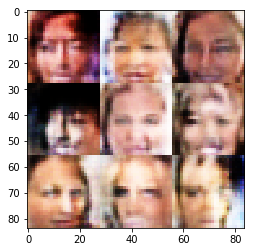

Epoch 1/1... Discriminator Loss: 0.1433... Generator Loss: 3.8364
Epoch 1/1... Discriminator Loss: 0.2613... Generator Loss: 3.5870
Epoch 1/1... Discriminator Loss: 0.8397... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 0.2857... Generator Loss: 1.8358
Epoch 1/1... Discriminator Loss: 0.1810... Generator Loss: 2.8160


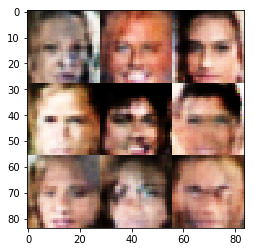

Epoch 1/1... Discriminator Loss: 0.2647... Generator Loss: 3.5383
Epoch 1/1... Discriminator Loss: 0.2905... Generator Loss: 4.3319
Epoch 1/1... Discriminator Loss: 0.1748... Generator Loss: 2.6979
Epoch 1/1... Discriminator Loss: 0.9373... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 0.1689... Generator Loss: 4.6955


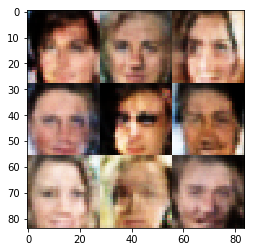

Epoch 1/1... Discriminator Loss: 0.5073... Generator Loss: 1.1983
Epoch 1/1... Discriminator Loss: 0.8697... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 0.3274... Generator Loss: 5.6703
Epoch 1/1... Discriminator Loss: 0.2290... Generator Loss: 2.8696
Epoch 1/1... Discriminator Loss: 0.1247... Generator Loss: 3.3824


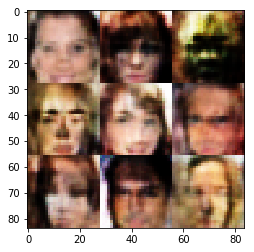

Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 0.5351
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 0.2464... Generator Loss: 3.3908
Epoch 1/1... Discriminator Loss: 0.4055... Generator Loss: 2.6929
Epoch 1/1... Discriminator Loss: 0.2467... Generator Loss: 2.7933


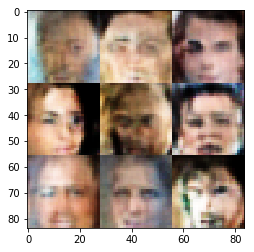

Epoch 1/1... Discriminator Loss: 0.6148... Generator Loss: 4.5830
Epoch 1/1... Discriminator Loss: 0.1534... Generator Loss: 3.6209
Epoch 1/1... Discriminator Loss: 0.2707... Generator Loss: 1.9634
Epoch 1/1... Discriminator Loss: 0.2390... Generator Loss: 3.7934
Epoch 1/1... Discriminator Loss: 0.2913... Generator Loss: 2.1845


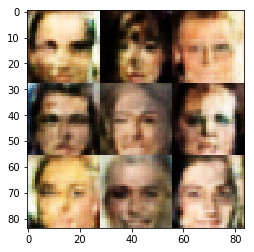

Epoch 1/1... Discriminator Loss: 0.1859... Generator Loss: 3.0588
Epoch 1/1... Discriminator Loss: 0.2242... Generator Loss: 2.0278
Epoch 1/1... Discriminator Loss: 0.1566... Generator Loss: 3.1801
Epoch 1/1... Discriminator Loss: 0.1476... Generator Loss: 2.8316
Epoch 1/1... Discriminator Loss: 0.1481... Generator Loss: 3.8087


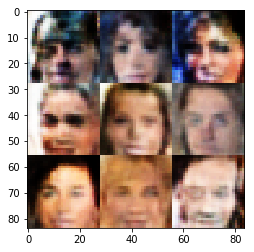

Epoch 1/1... Discriminator Loss: 0.1909... Generator Loss: 3.7140
Epoch 1/1... Discriminator Loss: 0.4022... Generator Loss: 3.9248
Epoch 1/1... Discriminator Loss: 0.3311... Generator Loss: 5.6348
Epoch 1/1... Discriminator Loss: 0.3444... Generator Loss: 1.6518
Epoch 1/1... Discriminator Loss: 0.2107... Generator Loss: 2.1999


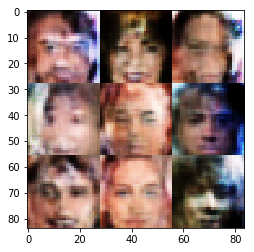

Epoch 1/1... Discriminator Loss: 0.5589... Generator Loss: 1.1143
Epoch 1/1... Discriminator Loss: 0.0793... Generator Loss: 3.9620
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 0.5032
Epoch 1/1... Discriminator Loss: 0.1884... Generator Loss: 3.7230
Epoch 1/1... Discriminator Loss: 0.1974... Generator Loss: 2.8504


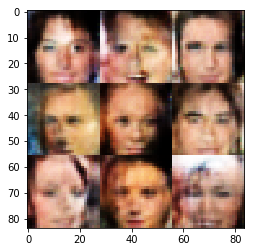

Epoch 1/1... Discriminator Loss: 0.1361... Generator Loss: 5.6222
Epoch 1/1... Discriminator Loss: 0.0952... Generator Loss: 7.0231
Epoch 1/1... Discriminator Loss: 0.0705... Generator Loss: 4.1452
Epoch 1/1... Discriminator Loss: 0.0661... Generator Loss: 4.6873
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.5235


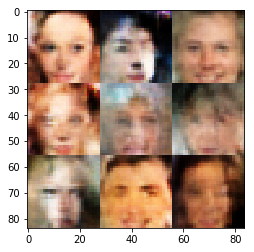

Epoch 1/1... Discriminator Loss: 0.9517... Generator Loss: 1.7537
Epoch 1/1... Discriminator Loss: 0.6226... Generator Loss: 1.3470


KeyboardInterrupt: 

In [14]:
batch_size = 50
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.